# Classification Project - German U-Boats of World War II

In [89]:
import numpy as np
import optuna
import shap
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, make_scorer, classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier

##### 
- Zdroj dat: https://www.kaggle.com/datasets/cormac42/ww2-u-boats
- Dataset obsahuje informace o německých ponorkách z druhé světové války.
- Data jsou scrapována z wikipedie.


## Preprocessing

In [2]:
# Load the data
df = pd.read_csv('uboats.csv')
df

Name  Year   Type                                 Notable Commanders  \
0        U-1  1935    IIA                                       Klaus Ewerth   
1        U-2  1935    IIA  Hans Heidtmann,Heinrich Liebe,Helmut Rosenbaum...   
2        U-3  1935    IIA  Joachim Schepke,Otto von Bülow,Hans-Hartwig Tr...   
3        U-4  1935    IIA                                Heinz-Otto Schultze   
4        U-5  1935    IIA                       Heinrich Lehmann-Willenbrock   
...      ...   ...    ...                                                ...   
1148  U-4707  1945  XXIII                                                NaN   
1149  U-4709  1945  XXIII                                                NaN   
1150  U-4710  1945  XXIII                              Ludwig von Friedeburg   
1151  U-4711  1945  XXIII                                                NaN   
1152  U-4712  1945  XXIII                                                NaN   

      Warships_sunk_n_total_loss_No Warships_sunk_n_total_loss_Tons-n-GRT  \
0                                 0                                     0   
1                                 0                                     0   
2                                 0                                     0   
3                                 1                                 1,090   
4                                 0                                     0   
...                             ...                                   ...   
1148                              0                                     0   
1149                              0                                     0   
1150                              0                                     0   
1151                              0                                     0   
1152                              0                                     0   

      Warships_Damaged_No Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
0                       0                           0                       0   
1                       0                           0                       0   
2                       0                           0                       2   
3                       0                           0                       3   
4                       0                           0                       0   
...                   ...                         ...                     ...   
1148                    0                           0                       0   
1149                    0                           0                       0   
1150                    0                           0                       0   
1151                    0                           0                       0   
1152                    0                           0                       0   

     Merchant_Ships_sunk_GRT  ...          Notes  \
0                          0  ...  Struck a mine   
1                          0  ...  Training boat   
2                      2,348  ...            NaN   
3                      5,133  ...            NaN   
4                          0  ...       Accident   
...                      ...  ...            ...   
1148                       0  ...            NaN   
1149                       0  ...            NaN   
1150                       0  ...            NaN   
1151                       0  ...            NaN   
1152                       0  ...            NaN   

                                                    URL  Commissioned  \
0     https://en.wikipedia.org/wiki/German_submarine...    1935-06-29   
1     https://en.wikipedia.org/wiki/German_submarine...    1935-07-25   
2     https://en.wikipedia.org/wiki/German_submarine...    1935-09-06   
3     https://en.wikipedia.org/wiki/German_submarine...    1935-08-17   
4     https://en.wikipedia.org/wiki/German_submarine...    1935-08-31   
...                                                 ...           ...   
1148  https:/

### Popis datasetu
- Dataset obsahuje 1153 ponerek vyrobených Německem od roku 1935 do roku 1945.
- Neobsahuje ponorky, které byly německem ukořistěny a použity německým námořnictvem.

### Popis sloupců
- **Name** - název ponorky
- **Year** - rok, kdy byla ponorka spuštěna na vodu
- **Type** - typ ponorky
- **Notable Commanders** - významní velitelé ponorky
- **Warships_sunk_n_total_loss_No** - počet potopených válečných lodí
- **Warships_sunk_n_total_loss_Tons-n-GRT** - celková tonáž potopených válečných lodí
- **Warships_Damaged_No** - počet válečných lodí, které byly poškozeny
- **Warships_Damaged_Tons-n-GRT** - celková tonáž válečných lodí, které byly poškozeny
- **Merchant_Ships_sunk_No** - počet potopených obchodních lodí
- **Merchant_Ships_sunk_GRT** - celková tonáž potopených obchodních lodí
- **Merchant_Ships_Damaged_No** - počet obchodních lodí, které byly poškozeny
- **Merchant_Ships_Damaged_GRT** - celková tonáž obchodních lodí, které byly poškozeny
- **Merchant_Ships_total_loss_No** - počet obchodních lodí, které byly ztraceny
- **Merchant_Ships_total_loss_GRT** - celková tonáž obchodních lodí, které byly ztraceny
- **Fate_Event** - osud ponorky
- **Fate_Date** - datum, kdy k osudu ponorky došlo
- **Notes** - poznámky(Např. název lodě, která ponorku potopila; způsob potopení; způsob použití; atd.)
- **URL** - odkaz na wikipedii
- **Commissioned** - datum, kdy byla ponorka zařazena do služby
- **Patrols** - informace o hlídkách vykonaných ponorkou ve formátu: 'Počet hlídek:číslo hlídky:datum začátku - datum konce číslo hlídky:datum začátku - datum konce ...'
- **Patrols_Count** - počet hlídek
- **Wolfpacks** - slovník s informacemi o vlčích smečkách, ve kterých ponorka operovala ve formátu: {'Jméno vlčí smečky': 'datum začátku - datum konce'}
- **Wolfpacks_Count** - počet vlčích smeček
- **Flotilla** - flotily, ke kterým ponorka patřila
- **Flotilla_Count** - počet flotil ke kterým ponorka patřila
- **Last_Flotilla** - poslední flotila, ke které ponorka patřila

### Encoding číselných atributů
- Některé atributy s čísly jsou načteny jako stringy
    - Tyto atributy budou převedeny na čísla
- Atributy s datumy budou převedeny na samostatné sloupce pro rok, měsíc a den
    - Bude vytvořen sloupec pro kosinus měsíce a dne, aby model mohl pochopit cyklickou povahu času
        - Kdy například prosinec a leden mají kladnou hodnotu blízko sebe a červenec a srpen zápornou blízko sebe

In [3]:
# convert columns with numbers which were read as strings to numbers
df['Warships_sunk_n_total_loss_Tons-n-GRT'] = df['Warships_sunk_n_total_loss_Tons-n-GRT'].str.replace(',', '').astype(float)
df['Warships_Damaged_Tons-n-GRT'] = df['Warships_Damaged_Tons-n-GRT'].str.replace(',', '').astype(float)
df['Merchant_Ships_sunk_GRT'] = df['Merchant_Ships_sunk_GRT'].str.replace(',', '').astype(float)
df['Merchant_Ships_damaged_GRT'] = df['Merchant_Ships_damaged_GRT'].str.replace(',', '').astype(float)
df['Merchant_Ships_total_loss_GRT'] = df['Merchant_Ships_total_loss_GRT'].str.replace(',', '').astype(float)

In [4]:
df.describe()

Year  Warships_sunk_n_total_loss_No  \
count 1153.00                        1153.00   
mean  1942.15                           0.26   
std      1.85                           0.70   
min   1935.00                           0.00   
25%   1941.00                           0.00   
50%   1942.00                           0.00   
75%   1943.00                           0.00   
max   1945.00                          10.00   

       Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
count                                1153.00              1153.00   
mean                                  622.28                 0.05   
std                                  3146.67                 0.26   
min                                     0.00                 0.00   
25%                                     0.00                 0.00   
50%                                     0.00                 0.00   
75%                                     0.00                 0.00   
max                                 46440.00                 3.00   

       Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
count                      1153.00                 1153.00   
mean                        275.05                    2.32   
std                        2235.58                    5.82   
min                           0.00                    0.00   
25%                           0.00                    0.00   
50%                           0.00                    0.00   
75%                           0.00                    2.00   
max                       39346.00                   53.00   

       Merchant_Ships_sunk_GRT  Merchant_Ships_damaged_No  \
count                  1153.00                    1153.00   
mean                  11554.21                       0.30   
std                   30600.82                       0.83   
min                       0.00                       0.00   
25%                       0.00                       0.00   
50%                       0.00                       0.00   
75%                    8133.00                       0.00   
max                  299477.00                       8.00   

       Merchant_Ships_damaged_GRT  Merchant_Ships_total_loss_No  \
count                     1153.00                       1153.00   
mean                      2105.47                          0.06   
std                       6127.36                          0.30   
min                          0.00                          0.00   
25%                          0.00                          0.00   
50%                          0.00                          0.00   
75%                          0.00                          0.00   
max                      62751.00                          3.00   

       Merchant_Ships_total_loss_GRT  Patrols_Count  Wolfpacks_Count  \
count                        1153.00        1153.00          1153.00   
mean                          387.90           3.02             1.75   
std                          1972.01           3.60             3.43   
min                             0.00           0.00             0.00   
25%                             0.00           0.00             0.00   
50%                             0.00           2.00             0.00   
75%                             0.00           4.00             2.00   
max                         24338.00          20.00            21.00   

       Flotilla_Count  
count         1153.00  
mean             2.12  
std              0.93  
min              1.00  
25%              2.00  
50%              2.00  
75%              3.00  
max              7.00

### Missing values
- Notable Commanders - ponorky nemusí mít významné velitele
- Wolfpacks - ponorky nemusí být součástí vlčí smečky
- Patrols - ponorky nemusí mít žádné vykonané hlídky
- Notes - poznámky nejsou povinné
- Fate_Date
    - Jedná se o ponorky:
        - Všechny 3 úmyslně zničeny během operace Regenbogen (Datum nejspíš kolem 2-3. května 1945)
        - U-2505 - Doplněno z textu - 3. května 1945
        - U-3004 - Doplněno z textu - 2. května 1945
        - U-3506 - Doplněno z textu - 2. května 1945
- Commissioned
    - Jedná se o ponorky 
        - U-118 - Na wikipedii jsou uvedené 2 datumy, 23. září 1941 a 6. Prosince 1941
                - Bylo vybráno datum 6 Prosince 1941, protože je z důvěryhodnějšího zdroje
        - U-128 - Nejspíš chyba parseru, nejspíš protože na wikipedii je za datumem uvedeno, kým byla ponorka uváděna na vodu
                - opraveno na 12. května 1941

In [5]:
# print table where will be each column with its name, type, number of missing values and unique values
def print_columns_descrbition(df):
    tab = pd.DataFrame(columns=['column_name', 'type', 'missing', 'unique'])
    for col in df.columns:
        new_row = pd.DataFrame({'column_name': [col], 'type': [df[col].dtype], 'missing': [df[col].isnull().sum()], 'unique': [df[col].nunique()]})
        tab = pd.concat([tab, new_row], ignore_index=True)
    return tab

# print number of rows and columns
print(f"Table with some description of columns:\nOriginal dataset has {df.shape[0]} rows and {df.shape[1]} columns")
print_columns_descrbition(df)

Table with some description of columns:
Original dataset has 1153 rows and 26 columns


column_name     type missing unique
0                                    Name   object       0   1153
1                                    Year    int64       0     11
2                                    Type   object       0     24
3                      Notable Commanders   object     935    169
4           Warships_sunk_n_total_loss_No    int64       0      7
5   Warships_sunk_n_total_loss_Tons-n-GRT  float64       0    156
6                     Warships_Damaged_No    int64       0      4
7             Warships_Damaged_Tons-n-GRT  float64       0     46
8                  Merchant_Ships_sunk_No    int64       0     39
9                 Merchant_Ships_sunk_GRT  float64       0    423
10              Merchant_Ships_damaged_No    int64       0      7
11             Merchant_Ships_damaged_GRT  float64       0    188
12           Merchant_Ships_total_loss_No    int64       0      4
13          Merchant_Ships_total_loss_GRT  float64       0     49
14                             Fate_Event   object       0     17
15                              Fate_Date   object       3    548
16                                  Notes   object     250    482
17                                    URL   object       0   1153
18                           Commissioned   object       2    803
19                                Patrols   object     296    852
20                          Patrols_Count    int64       0     20
21                              Wolfpacks   object     779    364
22                        Wolfpacks_Count    int64       0     21
23                               Flotilla   object       0   1147
24                         Flotilla_Count    int64       0      7
25                          Last_Flotilla   object       0     34

#### Chybné/nevhodné hodnoty
- U-92 - datum osudu může mít několik datumů
    - vybrán 12. listopad 1944 - datum vyřazení z provozu
- U-53 
    - datum osudu je 23 / 24 února 1940
    - bude vybráno 23. února 1940
- U-195, U-219, U-1197, U-1232
    - datum osudu je bez uvedeného dne
        - bude doplněn 15. den(prostřední den měsíce)
- U-984
    - u data osudu je napsáno, že se jedná o přibližnou hodnotu
        - odstranění komentáře
- U některých ponorek je uvedeno více osudných událostí, byla vybrána první
    - U-239 - 24. července 1944, 
    - U-952 - 12. července 1944, vyřazena z provozu
    - U-998 - 27. června 1944, vyřazena z provozu
    - U-1000 - 29. září 1944, vyřazena z provozu
- U-228 
    - u data osudu uveden rok 1944 - 1945
    - opraveno na  4. října 1944, ponorka byla potopena
- U-3501
    - u data osudu není jistý den
    - vybrán jeden z možných dnů, 5. května 1945

In [6]:
df_encoded = df.copy()

In [7]:
# show rows with missinf commission date
df_encoded[df_encoded['Commissioned'].isnull()]

Name  Year Type Notable Commanders  Warships_sunk_n_total_loss_No  \
113  U-118  1941   XB                NaN                              1   
123  U-128  1941  IXC       Ulrich Heyse                              0   

     Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
113                                 925.00                    0   
123                                   0.00                    0   

     Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
113                         0.00                       3   
123                         0.00                      12   

     Merchant_Ships_sunk_GRT  ...                     Notes  \
113                 14064.00  ...       US Avenger aircraft   
123                 83639.00  ...  USS Moffett & USS Jouett   

                                                   URL  Commissioned  \
113  https://en.wikipedia.org/wiki/German_submarine...           NaN   
123  https://en.wikipedia.org/wiki/German_submarine...           NaN   

                                               Patrols Patrols_Count  \
113  4 patrols:1st patrol:19 September - 16 October...             4   
123  6 patrols:1st patrol11 – 24 December 19412nd p...             6   

                                             Wolfpacks Wolfpacks_Count  \
113  {'Wotan': ['5', '7 October 1942'], 'Westwall':...               3   
123                                                NaN               0   

                                              Flotilla Flotilla_Count  \
113  {'4th U-boat Flotilla': ['6 December 1941 - 30...              3   
123  {'2nd U-boat Flotilla': ['12 May 1941 ', ' 17 ...              1   

            Last_Flotilla  
113  12th U-boat Flotilla  
123   2nd U-boat Flotilla  

[2 rows x 26 columns]

In [8]:
df_encoded.loc[df_encoded['Name'] == 'U-118', 'Commissioned'] = pd.to_datetime('1941-12-06')
df_encoded.loc[df_encoded['Name'] == 'U-128', 'Commissioned'] = pd.to_datetime('1941-05-12')

df_encoded[df_encoded['Commissioned'].isnull()]

Empty DataFrame
Columns: [Name, Year, Type, Notable Commanders, Warships_sunk_n_total_loss_No, Warships_sunk_n_total_loss_Tons-n-GRT, Warships_Damaged_No, Warships_Damaged_Tons-n-GRT, Merchant_Ships_sunk_No, Merchant_Ships_sunk_GRT, Merchant_Ships_damaged_No, Merchant_Ships_damaged_GRT, Merchant_Ships_total_loss_No, Merchant_Ships_total_loss_GRT, Fate_Event, Fate_Date, Notes, URL, Commissioned, Patrols, Patrols_Count, Wolfpacks, Wolfpacks_Count, Flotilla, Flotilla_Count, Last_Flotilla]
Index: []

[0 rows x 26 columns]

In [9]:
# show rows with missing fate date
df_encoded[df_encoded['Fate_Date'].isnull()]

Name  Year Type Notable Commanders  Warships_sunk_n_total_loss_No  \
1028  U-2505  1944  XXI                NaN                              0   
1074  U-3004  1944  XXI                NaN                              0   
1117  U-3506  1944  XXI     Gerhard Thäter                              0   

      Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
1028                                   0.00                    0   
1074                                   0.00                    0   
1117                                   0.00                    0   

      Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
1028                         0.00                       0   
1074                         0.00                       0   
1117                         0.00                       0   

      Merchant_Ships_sunk_GRT  ...           Notes  \
1028                     0.00  ...  Elbe II bunker   
1074                     0.00  ...  Elbe II bunker   
1117                     0.00  ...  Elbe II bunker   

                                                    URL  Commissioned  \
1028  https://en.wikipedia.org/wiki/German_submarine...    1944-11-07   
1074  https://en.wikipedia.org/wiki/German_submarine...    1944-08-30   
1117  https://en.wikipedia.org/wiki/German_submarine...    1944-10-16   

      Patrols Patrols_Count Wolfpacks Wolfpacks_Count  \
1028      NaN             0       NaN               0   
1074      NaN             0       NaN               0   
1117      NaN             0       NaN               0   

                                               Flotilla Flotilla_Count  \
1028  {'31st U-boat Flotilla': ['7 November 1944 ', ...              1   
1074  {'4th U-boat Flotilla': ['30 August 1944 ', ' ...              1   
1117  {'8th U-boat Flotilla': ['16 October 1944 ', '...              2   

             Last_Flotilla  
1028  31st U-boat Flotilla  
1074   4th U-boat Flotilla  
1117   5th U-boat Flotilla  

[3 rows x 26 columns]

In [10]:
# fill missing fate date as described above
df_encoded.loc[df_encoded['Name'] == 'U-2505', 'Fate_Date'] = '3 May 1945'
df_encoded.loc[df_encoded['Name'] == 'U-3004', 'Fate_Date'] = '2 May 1945'
df_encoded.loc[df_encoded['Name'] == 'U-3506', 'Fate_Date'] = '2 May 1945'

df_encoded[df_encoded['Fate_Date'].isnull()]

Empty DataFrame
Columns: [Name, Year, Type, Notable Commanders, Warships_sunk_n_total_loss_No, Warships_sunk_n_total_loss_Tons-n-GRT, Warships_Damaged_No, Warships_Damaged_Tons-n-GRT, Merchant_Ships_sunk_No, Merchant_Ships_sunk_GRT, Merchant_Ships_damaged_No, Merchant_Ships_damaged_GRT, Merchant_Ships_total_loss_No, Merchant_Ships_total_loss_GRT, Fate_Event, Fate_Date, Notes, URL, Commissioned, Patrols, Patrols_Count, Wolfpacks, Wolfpacks_Count, Flotilla, Flotilla_Count, Last_Flotilla]
Index: []

[0 rows x 26 columns]

In [11]:
# correct fate date for U-92 as described above
df_encoded.loc[df_encoded['Name'] == 'U-92', 'Fate_Date'] = '12 November 1944'
df_encoded.loc[df_encoded['Name'] == 'U-92', 'Fate_Event'] = 'Decommissioned'

In [12]:
# replace 23 / 24 February 1940 with 23 February 1940 on U-53 as described above
df_encoded.loc[df_encoded['Name'] == 'U-53', 'Fate_Date'] = '23 February 1940'

df_encoded[df_encoded['Name'] == 'U-195']

Name  Year  Type Notable Commanders  Warships_sunk_n_total_loss_No  \
190  U-195  1942  IXD1                NaN                              0   

     Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
190                                   0.00                    0   

     Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
190                         0.00                       2   

     Merchant_Ships_sunk_GRT  ...                      Notes  \
190                 14391.00  ...  Became Japanese sub I-506   

                                                   URL  Commissioned  \
190  https://en.wikipedia.org/wiki/German_submarine...    1942-09-05   

                                               Patrols Patrols_Count  \
190  3 patrols:1st patrol:20 March – 23 July 19432n...             3   

    Wolfpacks Wolfpacks_Count  \
190       NaN               0   

                                              Flotilla Flotilla_Count  \
190  {'4th U-boat Flotilla': ['5 September 1942 ', ...              3   

            Last_Flotilla  
190  33rd U-boat Flotilla  

[1 rows x 26 columns]

In [13]:
# find fate date without specified day - has only 1 space
df_encoded[df_encoded['Fate_Date'].str.count(' ') == 1]

Name  Year    Type Notable Commanders  Warships_sunk_n_total_loss_No  \
190   U-195  1942    IXD1                NaN                              0   
214   U-219  1942      XB                NaN                              0   
925  U-1197  1943    VIIC                NaN                              0   
950  U-1232  1943  IXC/40       Kurt Dobratz                              0   

     Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
190                                   0.00                    0   
214                                   0.00                    0   
925                                   0.00                    0   
950                                   0.00                    0   

     Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
190                         0.00                       2   
214                         0.00                       0   
925                         0.00                       0   
950                         0.00                       3   

     Merchant_Ships_sunk_GRT  ...                      Notes  \
190                 14391.00  ...  Became Japanese sub I-506   
214                     0.00  ...  Became Japanese sub I-505   
925                     0.00  ...                        NaN   
950                 17355.00  ...                        NaN   

                                                   URL  Commissioned  \
190  https://en.wikipedia.org/wiki/German_submarine...    1942-09-05   
214  https://en.wikipedia.org/wiki/German_submarine...    1942-12-12   
925  https://en.wikipedia.org/wiki/German_submarine...    1943-12-02   
950  https://en.wikipedia.org/wiki/German_submarine...    1944-03-08   

                                               Patrols Patrols_Count  \
190  3 patrols:1st patrol:20 March – 23 July 19432n...             3   
214  2 patrols:1st patrol:22 October 1943 - 1 Janua...             2   
925                                                NaN             0   
950       1 patrol:10 November 1944 – 14 February 1945             1   

    Wolfpacks Wolfpacks_Count  \
190       NaN               0   
214       NaN               0   
925       NaN               0   
950       NaN               0   

                                              Flotilla Flotilla_Count  \
190  {'4th U-boat Flotilla': ['5 September 1942 ', ...              3   
214  {'4th U-boat Flotilla': ['12 December 1942 - 3...              3   
925  {'21st U-boat Flotilla': ['2 December 1943 ', ...              2   
950  {'31st U-boat Flotilla': ['8 March ', ' 31 Oct...              2   

            Last_Flotilla  
190  33rd U-boat Flotilla  
214  33rd U-boat Flotilla  
925  31st U-boat Flotilla  
950  33rd U-boat Flotilla  

[4 rows x 26 columns]

In [14]:
# for u-boats with fate date without day, set day to 15
df_encoded.loc[df_encoded['Fate_Date'].str.count(' ') == 1, 'Fate_Date'] ='15 ' + df_encoded.loc[df_encoded['Fate_Date'].str.count(' ') == 1, 'Fate_Date'] 

df_encoded[df_encoded['Name'] == 'U-195']

Name  Year  Type Notable Commanders  Warships_sunk_n_total_loss_No  \
190  U-195  1942  IXD1                NaN                              0   

     Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
190                                   0.00                    0   

     Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
190                         0.00                       2   

     Merchant_Ships_sunk_GRT  ...                      Notes  \
190                 14391.00  ...  Became Japanese sub I-506   

                                                   URL  Commissioned  \
190  https://en.wikipedia.org/wiki/German_submarine...    1942-09-05   

                                               Patrols Patrols_Count  \
190  3 patrols:1st patrol:20 March – 23 July 19432n...             3   

    Wolfpacks Wolfpacks_Count  \
190       NaN               0   

                                              Flotilla Flotilla_Count  \
190  {'4th U-boat Flotilla': ['5 September 1942 ', ...              3   

            Last_Flotilla  
190  33rd U-boat Flotilla  

[1 rows x 26 columns]

In [15]:
# remove comment from fate date of U-984
df_encoded.loc[df_encoded['Name'] == 'U-984', 'Fate_Date'] = '2 August 1944'
df_encoded

Name  Year   Type                                 Notable Commanders  \
0        U-1  1935    IIA                                       Klaus Ewerth   
1        U-2  1935    IIA  Hans Heidtmann,Heinrich Liebe,Helmut Rosenbaum...   
2        U-3  1935    IIA  Joachim Schepke,Otto von Bülow,Hans-Hartwig Tr...   
3        U-4  1935    IIA                                Heinz-Otto Schultze   
4        U-5  1935    IIA                       Heinrich Lehmann-Willenbrock   
...      ...   ...    ...                                                ...   
1148  U-4707  1945  XXIII                                                NaN   
1149  U-4709  1945  XXIII                                                NaN   
1150  U-4710  1945  XXIII                              Ludwig von Friedeburg   
1151  U-4711  1945  XXIII                                                NaN   
1152  U-4712  1945  XXIII                                                NaN   

      Warships_sunk_n_total_loss_No  Warships_sunk_n_total_loss_Tons-n-GRT  \
0                                 0                                   0.00   
1                                 0                                   0.00   
2                                 0                                   0.00   
3                                 1                                1090.00   
4                                 0                                   0.00   
...                             ...                                    ...   
1148                              0                                   0.00   
1149                              0                                   0.00   
1150                              0                                   0.00   
1151                              0                                   0.00   
1152                              0                                   0.00   

      Warships_Damaged_No  Warships_Damaged_Tons-n-GRT  \
0                       0                         0.00   
1                       0                         0.00   
2                       0                         0.00   
3                       0                         0.00   
4                       0                         0.00   
...                   ...                          ...   
1148                    0                         0.00   
1149                    0                         0.00   
1150                    0                         0.00   
1151                    0                         0.00   
1152                    0                         0.00   

      Merchant_Ships_sunk_No  Merchant_Ships_sunk_GRT  ...          Notes  \
0                          0                     0.00  ...  Struck a mine   
1                          0                     0.00  ...  Training boat   
2                          2                  2348.00  ...            NaN   
3                          3                  5133.00  ...            NaN   
4                          0                     0.00  ...       Accident   
...                      ...                      ...  ...            ...   
1148                       0                     0.00  ...            NaN   
1149                       0                     0.00  ...            NaN   
1150                       0                     0.00  ...            NaN   
1151                       0                     0.00  ...            NaN   
1152                       0                     0.00  ...            NaN   

                                                    URL  Commissioned  \
0     https://en.wikipedia.org/wiki/German_submarine...    1935-06-29   
1     https://en.wikipedia.org/wiki/German_submarine...    1935-07-25   
2     https://en.wikipedia.org/wiki/German_submarine...    1935-09-06   
3     https://en.wikipedia.org/wiki/German_submarine...    1935-08-17   
4     https://en.wikipedia.org/wiki/German_submarine...    1935-08-31   
...                                               

In [16]:
# show unique fate events
df_encoded['Fate_Event'].unique()

array(['Sunk', 'Stricken', 'Scuttled', 'Scrapped', 'Missing',
       'Decommissioned', 'Captured', 'Surrendered', 'Broken up', 'Sold',
       'Interned, then sold', 'Ran aground & destroyed', 'Destroyed',
       'Interned', 'Grounded', 'Buried', 'Aground'], dtype=object)

In [17]:
# show fate date with len < 10
# print the names of u-boats with fate date with length less than 10
df_encoded[df_encoded['Fate_Date'].str.len() < 10]['Fate_Event']

234    Broken up
809    Broken up
854     Scrapped
856     Scrapped
Name: Fate_Event, dtype: object

In [18]:
df_encoded[df_encoded['Fate_Date'].str.len() < 10]['Name']

234     U-239
809     U-952
854     U-998
856    U-1000
Name: Name, dtype: object

In [19]:
# correct fate date for U-239, U-952, U-998, U-1000
df_encoded.loc[df_encoded['Name'] == 'U-239', 'Fate_Date'] = '24 July 1944'
df_encoded.loc[df_encoded['Name'] == 'U-952', 'Fate_Date'] = '12 July 1944'
df_encoded.loc[df_encoded['Name'] == 'U-952', 'Fate_Event'] = 'Decommissioned'
df_encoded.loc[df_encoded['Name'] == 'U-998', 'Fate_Date'] = '27 June 1944'
df_encoded.loc[df_encoded['Name'] == 'U-998', 'Fate_Event'] = 'Decommissioned'
df_encoded.loc[df_encoded['Name'] == 'U-1000', 'Fate_Date'] = '29 September 1944'
df_encoded.loc[df_encoded['Name'] == 'U-1000', 'Fate_Event'] = 'Decommissioned'

In [20]:
# show fate date which contains character '-'
df_encoded[df_encoded['Fate_Date'].str.contains('–')]

Name  Year  Type Notable Commanders  Warships_sunk_n_total_loss_No  \
223  U-228  1942  VIIC                NaN                              0   

     Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
223                                   0.00                    0   

     Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
223                         0.00                       0   

     Merchant_Ships_sunk_GRT  ...                 Notes  \
223                     0.00  ...  Shot down 2 aircraft   

                                                   URL  Commissioned  \
223  https://en.wikipedia.org/wiki/German_submarine...    1942-09-12   

                                               Patrols Patrols_Count  \
223  6 patrols:1st patrol:6 February – 29 March 194...             6   

    Wolfpacks Wolfpacks_Count  \
223       NaN               0   

                                              Flotilla Flotilla_Count  \
223  {'5th U-boat Flotilla': ['12 September 1942 ',...              2   

           Last_Flotilla  
223  6th U-boat Flotilla  

[1 rows x 26 columns]

In [21]:
# correct fate date and event for U-228
df_encoded.loc[df_encoded['Name'] == 'U-228', 'Fate_Date'] = '4 October 1944'
df_encoded.loc[df_encoded['Name'] == 'U-228', 'Fate_Event'] = 'Sunk'

In [22]:
df_encoded[df_encoded['Fate_Date'].str.contains('or')]

Name  Year Type Notable Commanders  Warships_sunk_n_total_loss_No  \
1112  U-3501  1944  XXI                NaN                              0   

      Warships_sunk_n_total_loss_Tons-n-GRT  Warships_Damaged_No  \
1112                                   0.00                    0   

      Warships_Damaged_Tons-n-GRT  Merchant_Ships_sunk_No  \
1112                         0.00                       0   

      Merchant_Ships_sunk_GRT  ...  Notes  \
1112                     0.00  ...    NaN   

                                                    URL  Commissioned  \
1112  https://en.wikipedia.org/wiki/German_submarine...    1944-07-29   

      Patrols Patrols_Count Wolfpacks Wolfpacks_Count  \
1112      NaN             0       NaN               0   

                                               Flotilla Flotilla_Count  \
1112  {'8th U-boat Flotilla': ['29 July ', ' 1 Novem...              2   

            Last_Flotilla  
1112  5th U-boat Flotilla  

[1 rows x 26 columns]

In [23]:
# correct fate date for U-3501
df_encoded.loc[df_encoded['Name'] == 'U-3501', 'Fate_Date'] = '5 May 1945'

### Encoding kategorických sloupců
- Sloupce Name, Notes, URL nebudou použity pro shlukování
- Na sloupec Fate_Event bude použita one-hot encoding
    - V originálních datech je použito 17 různých hodnot
    - Většina z nich je zastoupena v nízkých jednotkách případů a navíc vlastně vypovídají o stejném osudu ponorky
    - Po ruční analýze jednotlivých případů byly sloučenny následující hodnoty:  
        - Sunk, Destroy, Ran aground & destroyed, Destroyed, Grounded
            - Všechny tyto hodnoty znamenají, že ponorka byla zničena
        - Scuttled, Aground, Buried
            - Všechny tyto hodnoty znamenají, že ponorka byla umýslně zničena posádkou nebo personálem
        - Decommissioned, Broken up, Scrapped, Sold, Stricken
            - Všechny tyto hodnoty znamenají, že ponorka byla vyřazena z provozu. Ať už z důvodu zastaralosti, poškození nebo jiného důvodu
                - Přidání Stricken(zasažena) by se nemuselo zdát na první pohled jasné, ale většinou poté došlo k vyřazení z provozu a sešrotování/rozebrání na náhradní díly
        - Surrendered, Interned, 'Interned, then sold', Captured
            - V poslední kategorii jsou ponorky, jejichž posádky se byly nuceny vzdát/byly zajaty
        - V poslední kategorii zůstávají pouze ztracené ponorky(missing) 
    - Rozdělení do jednotlivých kategorii není vždy jasné a pokud se chce zabránit situaci s velkým množstvím kategorii s nízkým počtem případů. Budou se kategorie mírně překrývat
    - Tímto bylo sníženo množství hodnot ze 17 na 5
- Atributy Flotilla a Last_Flotilla se sloučí do jednoho atributu Flotilla
    - Na ten bude použit one-hot encoding a bude zahrnovat všechny flotily, ke kterým ponorka patřila(bez rozsahu kdy ke flotile patřila)
    - Odstraněné duplicitní hodnoty
        - Stejný název, ale různé velké a malé písmena
        - '\[1]' za názvem flotily(nejspíše odkaz na zdroj dat)
        - Takto vznikne 29 unikátních hodnot (stejný počet jako je U-boat flotil viz. https://en.wikipedia.org/wiki/List_of_U-boat_flotillas)
            - Některé ovšem mají jiný název, než je uvedeno na wikipedii 
                - Např. u-boat training flotilla, která v seznamu na wikipedii není
                - 20th U-boat Flotilla, která se v datasetu nevyskytuje
- Wolfpacks
    - Na rozíl od Flottily, je zde velký počet unikátních vlčích smeček(241)
    - Tento atribut bude zahozen(časová náročnost na zpracování)
        - Možné zpracování tohoto atributu by bylo spočítat celkový počet dnů strávený ve vlčí smečce a přidat tento atribut do datasetu 
- Notable commanders
    - Velký počet unikátních hodnot
    - Většina ponorek nemá žádné
    - Atribut se převede na binární hodnotu, zda ponorka měla významného velitele
- Type
    - 24 unikátních hodnot
    - některé typy jsou si podobné (IIA, IIB, IIC, IID), ale i tak se mezi nimi vyskytují rozdíly. Budou ponechány tak jak jsou
    - Bude použit one-hot encoding 
- Patrols
    - Obsahuje informace o hlídkách a jak dlouho v nich ponorka byla
    - Mohlo by být použito jako atribut, který by zahrnoval celkový počet dnů strávených na hlídkách
    - Atribut bude zahozen(časová náročnost na zpracování) 

#### Fate_Event

In [24]:
print_columns_descrbition(df_encoded)

column_name     type missing unique
0                                    Name   object       0   1153
1                                    Year    int64       0     11
2                                    Type   object       0     24
3                      Notable Commanders   object     935    169
4           Warships_sunk_n_total_loss_No    int64       0      7
5   Warships_sunk_n_total_loss_Tons-n-GRT  float64       0    156
6                     Warships_Damaged_No    int64       0      4
7             Warships_Damaged_Tons-n-GRT  float64       0     46
8                  Merchant_Ships_sunk_No    int64       0     39
9                 Merchant_Ships_sunk_GRT  float64       0    423
10              Merchant_Ships_damaged_No    int64       0      7
11             Merchant_Ships_damaged_GRT  float64       0    188
12           Merchant_Ships_total_loss_No    int64       0      4
13          Merchant_Ships_total_loss_GRT  float64       0     49
14                             Fate_Event   object       0     17
15                              Fate_Date   object       0    542
16                                  Notes   object     250    482
17                                    URL   object       0   1153
18                           Commissioned   object       0    805
19                                Patrols   object     296    852
20                          Patrols_Count    int64       0     20
21                              Wolfpacks   object     779    364
22                        Wolfpacks_Count    int64       0     21
23                               Flotilla   object       0   1147
24                         Flotilla_Count    int64       0      7
25                          Last_Flotilla   object       0     34

In [25]:
# columns Name, Notes, URL wont be used for clustering
df_encoded = df_encoded.drop(columns=['Name', 'Notes', 'URL'])

In [26]:
# show unique fate events
print(sorted(df_encoded['Fate_Event'].unique()))

['Aground', 'Broken up', 'Buried', 'Captured', 'Decommissioned', 'Destroyed', 'Grounded', 'Interned', 'Interned, then sold', 'Missing', 'Ran aground & destroyed', 'Scrapped', 'Scuttled', 'Sold', 'Stricken', 'Sunk', 'Surrendered']


In [27]:
fate_event_counts = df_encoded['Fate_Event'].value_counts().sort_index()
print(fate_event_counts)

Fate_Event
Aground                      1
Broken up                    2
Buried                       3
Captured                     6
Decommissioned               5
Destroyed                    1
Grounded                     1
Interned                     1
Interned, then sold          1
Missing                     45
Ran aground & destroyed      1
Scrapped                     2
Scuttled                   268
Sold                         1
Stricken                    15
Sunk                       651
Surrendered                149
Name: count, dtype: int64


In [28]:
fate_event_counts = df_encoded['Fate_Event'].value_counts().sort_values(ascending=False)
print(fate_event_counts)

Fate_Event
Sunk                       651
Scuttled                   268
Surrendered                149
Missing                     45
Stricken                    15
Captured                     6
Decommissioned               5
Buried                       3
Scrapped                     2
Broken up                    2
Sold                         1
Ran aground & destroyed      1
Interned, then sold          1
Destroyed                    1
Interned                     1
Grounded                     1
Aground                      1
Name: count, dtype: int64


In [29]:
# show all rows which have fate_event with frequency less than 3
df_encoded[df_encoded['Fate_Event'].isin(fate_event_counts[fate_event_counts < 16].index)]

Year     Type                                 Notable Commanders  \
2     1935      IIA  Joachim Schepke,Otto von Bülow,Hans-Hartwig Tr...   
3     1935      IIA                                Heinz-Otto Schultze   
5     1935      IIA                                    Adalbert Schnee   
9     1935      IIB  Herbert Sohler,Georg-Wilhelm Schulz,Rolf Mütze...   
20    1936      IIB              Fritz Frauenheim,Hans-Heinrich Döhler   
80    1941     VIIC           Friedrich Guggenberger,Johann-Otto Krieg   
91    1942     VIIC                                                NaN   
109   1940      IXB                                  Fritz-Julius Lemp   
234   1943     VIIC                                                NaN   
251   1941     VIIC                       Heinrich Lehmann-Willenbrock   
257   1942     VIIC                                       Heinz Franke   
338   1943     VIIC                                                NaN   
429   1941     VIIC                                                NaN   
486   1941      IXC                                      Peter Zschech   
491   1941      IXC                           Karl Neitzel,Alfred Eick   
492   1941      IXC                                                NaN   
551   1941     VIIC                                                NaN   
554   1941     VIIC                                                NaN   
598   1942     VIIC                  Albrecht Brandi,Günther Heydemann   
663   1944     VIIC                                                NaN   
714   1942     VIIC                                     Gerhard Bigalk   
716   1942     VIIC                                                NaN   
722   1943     VIIC                                                NaN   
781   1943     IXD2                                                NaN   
809   1942     VIIC                                                NaN   
814   1942     VIIC                                     Gerhard Schaar   
842   1943     VIIC                                                NaN   
854   1943  VIIC/41                                                NaN   
856   1943  VIIC/41                                                NaN   
878   1944  VIIC/41                                                NaN   
883   1944     VIIC                                                NaN   
889   1943     VIIF                                                NaN   
910   1943  VIIC/41                                                NaN   
925   1943     VIIC                                                NaN   
950   1943   IXC/40                                       Kurt Dobratz   
1028  1944      XXI                                                NaN   
1069  1945      XXI                                     Gerhard Schaar   
1074  1944      XXI                                                NaN   
1113  1944      XXI                                                NaN   
1117  1944      XXI                                     Gerhard Thäter   

      Warships_sunk_n_total_loss_No  Warships_sunk_n_total_loss_Tons-n-GRT  \
2                                 0                                   0.00   
3                                 1                                1090.00   
5                                 0                                   0.00   
9                                 0                                   0.00   
20                                1                                 605.00   
80                                2                               23750.00   
91                                1                                1625.00   
109                               0                                   0.00   
234                               0                                   0.00   
251                               1                                1300.00   
257                               1                                 925.00   
338                               0

In [30]:
# combine fate events Sunk, Destroyed, Ran aground & destroyed, Destroyed, Grounded
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Sunk', 'Destroyed', 'Ran aground & destroyed', 'Grounded'], 'Sunk')

In [31]:
# combine fate events Scuttled, Aground, Burried
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Scuttled', 'Aground', 'Buried'], 'Scuttled')

In [32]:
# combine fate events Decommissioned, Broken up, Scrapped, Sold
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Decommissioned', 'Broken up', 'Scrapped', 'Sold', 'Stricken'], 'Decommissioned')

In [33]:
# combine fate events Surrendered, Interned, 'Interned, then sold'
df_encoded['Fate_Event'] = df_encoded['Fate_Event'].replace(['Surrendered', 'Interned', 'Interned, then sold', 'Captured'], 'Surrendered')

In [34]:
fate_event_counts = df_encoded['Fate_Event'].value_counts().sort_values(ascending=False)
print(fate_event_counts)

Fate_Event
Sunk              654
Scuttled          272
Surrendered       157
Missing            45
Decommissioned     25
Name: count, dtype: int64


### Přidání cílové proměnné

In [35]:
# Target variable will be if the submarine was in service until the end of the war
# end of the war was on 8 May 1945. But after Doenitz's was appointed as the new head of state, many submarines were ordered to surrender
# So also the submarines which surendered after 30 April 1945 will be considered as survived
df_encoded['Survived'] = (
    (pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-04-29')) 
)


In [36]:
print(df_encoded['Survived'].value_counts())

Survived
False    746
True     407
Name: count, dtype: int64


In [37]:
df_encoded['Survived'] = (
    (pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-05-08')) |
    ((df_encoded['Fate_Event'] != 'Sunk') & 
     (pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-04-30')))
)


In [38]:
print(df_encoded['Survived'].value_counts())

Survived
False    767
True     386
Name: count, dtype: int64


In [39]:
# show submarines which were sunk between 30 April 1945 and 8 May 1945
df_encoded[(pd.to_datetime(df_encoded['Fate_Date']) > pd.to_datetime('1945-04-30')) & (pd.to_datetime(df_encoded['Fate_Date']) < pd.to_datetime('1945-05-08'))]

Year   Type                                 Notable Commanders  \
7     1935    IIB  Otto Schuhart,Heinrich Lehmann-Willenbrock,Eit...   
10    1935    IIB                  Hans-Rudolf Rösing,Viktor Schütze   
13    1935    IIB  Victor Oehrn,Herbert Wohlfarth,Gerhard Bigalk,...   
16    1935    IIB                                                NaN   
28    1936   VIIA      Otto Schuhart,Georg Lassen,Karl-Heinz Marbach   
...    ...    ...                                                ...   
1148  1945  XXIII                                                NaN   
1149  1945  XXIII                                                NaN   
1150  1945  XXIII                              Ludwig von Friedeburg   
1151  1945  XXIII                                                NaN   
1152  1945  XXIII                                                NaN   

      Warships_sunk_n_total_loss_No  Warships_sunk_n_total_loss_Tons-n-GRT  \
7                                 0                                   0.00   
10                                0                                   0.00   
13                                0                                   0.00   
16                                0                                   0.00   
28                                1                               22500.00   
...                             ...                                    ...   
1148                              0                                   0.00   
1149                              0                                   0.00   
1150                              0                                   0.00   
1151                              0                                   0.00   
1152                              0                                   0.00   

      Warships_Damaged_No  Warships_Damaged_Tons-n-GRT  \
7                       0                         0.00   
10                      0                         0.00   
13                      0                         0.00   
16                      0                         0.00   
28                      0                         0.00   
...                   ...                          ...   
1148                    0                         0.00   
1149                    0                         0.00   
1150                    0                         0.00   
1151                    0                         0.00   
1152                    0                         0.00   

      Merchant_Ships_sunk_No  Merchant_Ships_sunk_GRT  \
7                          0                     0.00   
10                         0                     0.00   
13                         9                 12344.00   
16                         3                  1825.00   
28                        12                 67277.00   
...                      ...                      ...   
1148                       0                     0.00   
1149                       0                     0.00   
1150                       0                     0.00   
1151                       0                     0.00   
1152                       0                     0.00   

      Merchant_Ships_damaged_No  ...   Fate_Date  Commissioned  \
7                             0  ...  5 May 1945    1935-08-05   
10                            0  ...  3 May 1945    1935-09-21   
13                            0  ...  5 May 1945    1936-01-18   
16                            0  ...  5 May 1945    1935-12-03   
28                            0  ...  5 May 1945    1936-11-16   
...                         ...  ...         ...           ...   
1148                          0  ...  5 May 1945    1945-02-20   
1149                          0  ...  4 May 1945    1945-03-03   
1150                          0  ...  5 May 1945    1945-05-01   
1151                          0  ...  4 May 1945    1945-03-21   
1152                          0  ...  3 May 1945    1945-04-03   

                             

### Encoding datumů

In [40]:
# encode datetime columns
# comissioned to column comissioned_year, comissioned_month, comissioned_day
df_encoded['Commissioned'] = pd.to_datetime(df_encoded['Commissioned'])
df_encoded['Commissioned_year'] = df_encoded['Commissioned'].dt.year
df_encoded['Commissioned_month'] = df_encoded['Commissioned'].dt.month
df_encoded['Commissioned_day'] = df_encoded['Commissioned'].dt.day

# make a cosine of month and day so that the model can understand the cyclical nature of time
df_encoded['Commissioned_month_cos'] = np.cos(2 * np.pi * df_encoded['Commissioned_month'] / 12)
df_encoded['Commissioned_day_cos'] = np.cos(2 * np.pi * df_encoded['Commissioned_day'] / 31)


# fate date to column fate_year, fate_month, fate_day
df_encoded['Fate_Date'] = pd.to_datetime(df_encoded['Fate_Date'])
df_encoded['Fate_year'] = df_encoded['Fate_Date'].dt.year
df_encoded['Fate_month'] = df_encoded['Fate_Date'].dt.month
df_encoded['Fate_day'] = df_encoded['Fate_Date'].dt.day

# make a cosine of month and day so that the model can understand the cyclical nature of time
df_encoded['Fate_month_cos'] = np.cos(2 * np.pi * df_encoded['Fate_month'] / 12)
df_encoded['Fate_day_cos'] = np.cos(2 * np.pi * df_encoded['Fate_day'] / 31)

# drop original columns
df_encoded = df_encoded.drop(columns=['Commissioned', 'Fate_Date', 'Commissioned_month', 'Commissioned_day', 'Fate_month', 'Fate_day'])

In [41]:
print_columns_descrbition(df_encoded)

column_name     type missing unique
0                                    Year    int64       0     11
1                                    Type   object       0     24
2                      Notable Commanders   object     935    169
3           Warships_sunk_n_total_loss_No    int64       0      7
4   Warships_sunk_n_total_loss_Tons-n-GRT  float64       0    156
5                     Warships_Damaged_No    int64       0      4
6             Warships_Damaged_Tons-n-GRT  float64       0     46
7                  Merchant_Ships_sunk_No    int64       0     39
8                 Merchant_Ships_sunk_GRT  float64       0    423
9               Merchant_Ships_damaged_No    int64       0      7
10             Merchant_Ships_damaged_GRT  float64       0    188
11           Merchant_Ships_total_loss_No    int64       0      4
12          Merchant_Ships_total_loss_GRT  float64       0     49
13                             Fate_Event   object       0      5
14                                Patrols   object     296    852
15                          Patrols_Count    int64       0     20
16                              Wolfpacks   object     779    364
17                        Wolfpacks_Count    int64       0     21
18                               Flotilla   object       0   1147
19                         Flotilla_Count    int64       0      7
20                          Last_Flotilla   object       0     34
21                               Survived     bool       0      2
22                      Commissioned_year    int32       0     11
23                 Commissioned_month_cos  float64       0     11
24                   Commissioned_day_cos  float64       0     26
25                              Fate_year    int32       0      8
26                         Fate_month_cos  float64       0     11
27                           Fate_day_cos  float64       0     26

### Odstranění informací přímo souvisejících s osudem ponorky

In [42]:
# Removal of fate dates
df_encoded = df_encoded.drop(columns=['Fate_year'])
df_encoded = df_encoded.drop(columns=['Fate_month_cos'])
df_encoded = df_encoded.drop(columns=['Fate_day_cos'])

# Removal of fate event
df_encoded = df_encoded.drop(columns=['Fate_Event'])

#### Flotilla

In [43]:
#{'1st U-boat Flotilla': ['1 September 1936 ', ' 1 August 1939'], '21st U-boat Flotilla': ['1 July 1940 ', ' 26 Aug 1942'], '30th U-boat Flotilla': ['3 June 1943 ', ' 10 September 1944']}
# Take keys from dictionary and make a list out of them. and remove '[1]' from the keys
flotilla_keys = list(df_encoded['Flotilla'].apply(lambda x: [str.lower(key.replace('[1]', '')) for key in eval(x).keys()] if pd.notnull(x) else []))

#make a set out of the lists in a list
flotilla_keys_unique = sorted(set([item for sublist in flotilla_keys for item in sublist]))
print(flotilla_keys_unique)
print(len(flotilla_keys_unique))

['10th u-boat flotilla', '11th u-boat flotilla', '12th u-boat flotilla', '13th u-boat flotilla', '14th u-boat flotilla', '18th u-boat flotilla', '19th u-boat flotilla', '1st u-boat flotilla', '1st u-boat training flotilla', '21st u-boat flotilla', '22nd u-boat flotilla', '23rd u-boat flotilla', '24th u-boat flotilla', '26th u-boat flotilla', '29th u-boat flotilla', '2nd u-boat flotilla', '30th u-boat flotilla', '31st u-boat flotilla', '32nd u-boat flotilla', '33rd u-boat flotilla', '3rd u-boat flotilla', '4th u-boat flotilla', '5th u-boat flotilla', '6th u-boat flotilla', '7th u-boat flotilla', '8th u-boat flotilla', '9th u-boat flotilla', 'u-boat school flotilla', 'u-boat training flotilla']
29


In [44]:
#make a set out of each sublist in a list
flotilla_keys = [set(sublist) for sublist in flotilla_keys]

# add the flothilla to the dataset
df_encoded['Flotilla'] = flotilla_keys

In [45]:
# 1-hot encoding for flotilla
for key in flotilla_keys_unique:
    df_encoded['Flotilla_' + key] = df_encoded['Flotilla'].apply(lambda x: True if key in x else False)

df_encoded = df_encoded.drop(columns=['Flotilla'])
df_encoded = df_encoded.drop(columns=['Last_Flotilla'])

#### Wolfpacks

In [46]:
# similar approach as for flotilla
wolfpacks_keys = list(df_encoded['Wolfpacks'].apply(lambda x: [str.lower(key.replace('[1]', '')) for key in eval(x).keys()] if pd.notnull(x) else []))

wolfpacks_keys_unique = sorted(set([item for sublist in wolfpacks_keys for item in sublist]))

print(wolfpacks_keys_unique)
print(len(wolfpacks_keys_unique))

['adler', 'amrum', 'amsel', 'amsel 1', 'amsel 2', 'amsel 3', 'amsel 4', 'arnauld', 'aufnahme', 'battle of the atlanti', 'benecke', 'blitz', 'blutrausch', 'blücher', 'boreas', 'borkum', 'borkum 1', 'borkum 2', 'borkum 3', 'bosemüller', 'brandenburg', 'breslau', 'bums', 'burggraf', 'busch, rainer; röll, hans-joachim', 'büffel', 'coronel', 'coronel 1', 'coronel 2', 'coronel 3', 'dachs', 'delphin', 'delphin ii', 'donau 1', 'donau 2', 'donau i\xa0[de]', 'donner', 'donner & keil', 'drachen', 'dragoner', 'draufgänger', 'drossel', 'dränger', 'eisbär', 'eisenbart', 'eisenhart 1', 'eisenhart 2', 'eisenhart 3', 'eisenhart 4', 'eisenhart 5', 'eisenhart 6', 'eisenhart 7', 'eisenhart 8', 'eisenhart 9', 'eisteufel', 'eiswolf', 'elbe', 'elbe 1', 'elbe 2', 'endrass', 'falke', 'faust', 'feuer', 'fink', 'föhr', 'geier 1', 'geier 2', 'geier 3', 'giese, otto; wise, james e.', 'goeben', 'gpx', 'greif', 'grimm', 'gröner, eric; jung, dieter; maass, martin', 'gröner, erich; jung, dieter; maass, martin', 'grönl

In [47]:
df_encoded = df_encoded.drop(columns=['Wolfpacks'])

#### Notable Commanders

In [48]:
# if there is a notable commander, set 1, otherwise 0
df_encoded['Notable Commanders'] = df_encoded['Notable Commanders'].apply(lambda x: 1 if pd.notnull(x) else 0)

#### Type

In [49]:
# count and print unique values
type_counts = df_encoded['Type'].value_counts().sort_values(ascending=False)
print(type_counts)

Type
VIIC       568
XXI        118
VIIC/41     91
IXC/40      87
XXIII       61
IXC         54
IXD2        28
VIIB        24
IIB         20
IID         16
IXB         14
XIV         10
VIIA        10
XB           8
IIC          8
IXA          8
VIID         6
IIA          6
XVIIA        4
VIIF         4
XVIIB        3
IA           2
IXD1         2
IXD/42       1
Name: count, dtype: int64


In [50]:
# one-hot encoding for type
df_encoded = pd.get_dummies(df_encoded, columns=['Type'])

#### Patrols

In [51]:
df_encoded = df_encoded.drop(columns=['Patrols'])

In [52]:
print_columns_descrbition(df_encoded)

column_name     type missing unique
0                                    Year    int64       0     11
1                      Notable Commanders    int64       0      2
2           Warships_sunk_n_total_loss_No    int64       0      7
3   Warships_sunk_n_total_loss_Tons-n-GRT  float64       0    156
4                     Warships_Damaged_No    int64       0      4
..                                    ...      ...     ...    ...
67                               Type_XIV     bool       0      2
68                             Type_XVIIA     bool       0      2
69                             Type_XVIIB     bool       0      2
70                               Type_XXI     bool       0      2
71                             Type_XXIII     bool       0      2

[72 rows x 4 columns]

## Explorace dat

### Correlation
- Velmi silné korelace(0.9 - 1):
    - počet potopených válečných lodí a celková tonáž potopených válečných lodí - (0.97)
    - počet potopených obchodních lodí a celková tonáž potopených obchodních lodí - (0.97)
    - počet ztracených obchodních lodí a celková tonáž ztracených obchodních lodí - (0.97)
        - U těchto 3 párů hodnot je korelace tak vysoká, protože čím více lodí bylo potopeno, tím vyšší byla celková tonáž
                - Jedinou vyjímkou je pokud některá ponorka potopila malý počet velkých lodí
    - Rok spuštění na vodu a rok zařazení do služby - (0.98)
        - Většina ponorek byla zařazena do služby nedlouho po spuštění na vodu
    - U těchto silných korelací by bylo vhodné jeden z párů hodnot odstranit
- Silné korelace(0.7 - 0.9):
    - V datasetu nejsou žádné silné korelace
- Střední korelace(0.5 - 0.7):
    - Počet poškozených válečných lodí a celková tonáž poškozených válečných lodí - (0.67)
        - Překvapivě je tato korelace významně nižší než u potopených válečných lodí a obchodních lodí
    - Čtveřice hodnot
        - počet poškozených obchodních lodí
        - počet potopených obchodních lodí
        - celková tonáž poškozených obchodních lodí
        - celková tonáž potopených obchodních lodí
        - všechny 4 hodnoty mají korelaci mezi 0.59 a 0.6
    - Rok spuštění na vodu, Rok zařazení do služby a Rok osudu - (0.59-0.6)
        - Velká čast ponorek skončila v provozu nedlouho po zařazení do služby
    - Významní velitelé a počet potopených obchodních lodí - (0.56)
        - Významní velitelé jsou zpravidla významní díky dobře vykonaným misím
        - Významné mise zpravidla zahrnovaly potopení obchodních lodí 
    - Rok spuštění na vodu a počet vykonaných hlídek - (-0.52) 
        - Ponorky spuštěné na vodu později měly méně času na vykonávání hlídek
- Slabé korelace(0.3 - 0.5): 
    - Slabých a velmi slabých korelací je v datasetu velké množství
    - Z těch zajímavějších:
        - Významní velitelé a počet potopených válečných lodí - (0.32)
        - Významní velitelé a počet poškozených válečných lodí - (0.23)
            - Významní velitelé se buď soustředili na obchodní lodě a nebo pokud se někomu podařilo potopit/poškodit válečnou loď, tak to byla spíše náhoda
            - Také je možné, že to je způsobeno malým množstvím potopených a poškozených válečných lodí 

In [53]:
# data without categorical columns
df_encoded_no_cat = df_encoded[[col for col in df_encoded.columns if not col.startswith(('Flotilla', 'Fate_Event', 'Type'))]]

In [54]:
# corelation matrix
correlation_matrix = df_encoded_no_cat.corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",
    color_continuous_scale="blues",
    aspect="equal",        
    width=1600,            
    height=1600            
)

# Optional: Improve layout aesthetics
fig.update_xaxes(side="bottom")  # Moves x-axis to the bottom

# Display the figure
fig.show()

In [55]:
# corealations oredered by value
correlation_matrix.unstack().sort_values(ascending=False)

Commissioned_day_cos           Commissioned_day_cos             1.00
Year                           Year                             1.00
Commissioned_month_cos         Commissioned_month_cos           1.00
Notable Commanders             Notable Commanders               1.00
Warships_sunk_n_total_loss_No  Warships_sunk_n_total_loss_No    1.00
                                                                ... 
Notable Commanders             Year                            -0.46
Year                           Patrols_Count                   -0.52
Patrols_Count                  Year                            -0.52
                               Commissioned_year               -0.53
Commissioned_year              Patrols_Count                   -0.53
Length: 324, dtype: float64

#### Odstranění silně korelovaných atributů 
- Budou odstraněny sloupce s korelací nad 0.96
    - U obchodních lodí byly odstraněny počty a zachovány tonáže
        - Tonáž by měla být lepší reprezentací úspěchů ponorek
- Rok spoštění na vodu
    - Rok zařazení do služby má větší význam - až od této doby mohla ponorka vykonávat mise

In [56]:
# drop columns with high correlation
df_encoded = df_encoded.drop(columns=['Merchant_Ships_sunk_No', 'Merchant_Ships_damaged_No', 'Merchant_Ships_total_loss_No', 'Year'])
df_encoded_no_cat = df_encoded_no_cat.drop(columns=['Merchant_Ships_sunk_No', 'Merchant_Ships_damaged_No', 'Merchant_Ships_total_loss_No', 'Year'])

### Outlieři
- Prakticky všechny číselné atributy obsahují outliery
    - S vyjímkou datumů
    - Ale roky nějaké outliery mají
        - Před začátkem války bylo vyráběno mnohem méně ponorek než během války
- Obzvláště hodně outlierů mají hodnoty měřící úspěchy ponorek    

In [57]:
# box plots for numerical columns using FacetGrid
g = sns.FacetGrid(df_encoded_no_cat.melt(), col='variable', col_wrap=4, sharex=False, sharey=False)

g.map(sns.boxplot, 'variable', 'value')

g.set_titles('{col_name}')
g.set_axis_labels('variable', 'value')
plt.tight_layout()
plt.show()

In [58]:
# distribution of numerical columns
df_encoded_no_cat.hist(figsize=(20, 20))
plt.show()

### Scaling
- Hodnoty v datasetu mají různé rozsahy a jednotky
- Vyskytují se zde outlieři
    - Nemusel by být špatný nápad použít RobustScaler


In [59]:
# MinMaxScaler
scaler = MinMaxScaler()
df_encoded_scaled_mm = df_encoded.copy()
df_encoded_scaled_mm[df_encoded_no_cat.columns] = scaler.fit_transform(df_encoded_no_cat)

# RobustScaler
scaler = RobustScaler()
df_encoded_scaled_rs = df_encoded.copy()
df_encoded_scaled_rs[df_encoded_no_cat.columns] = scaler.fit_transform(df_encoded_no_cat)

# StandardScaler
scaler = StandardScaler()
df_encoded_scaled_ss = df_encoded.copy()
df_encoded_scaled_ss[df_encoded_no_cat.columns] = scaler.fit_transform(df_encoded_no_cat)

# Only numerical columns
scaler = MinMaxScaler()
df_encoded_no_cat_scaled_mm = df_encoded_no_cat.copy()
df_encoded_no_cat_scaled_mm = scaler.fit_transform(df_encoded_no_cat)

scaler = RobustScaler()
df_encoded_no_cat_scaled_rs = df_encoded_no_cat.copy()
df_encoded_no_cat_scaled_rs = scaler.fit_transform(df_encoded_no_cat)

scaler = StandardScaler()
df_encoded_no_cat_scaled_ss = df_encoded_no_cat.copy()
df_encoded_no_cat_scaled_ss = scaler.fit_transform(df_encoded_no_cat)


In [60]:
df_encoded_no_cat_scaled_ss

array([[ 2.07098789, -0.37770241, -0.1978444 , ..., -3.91658875,
        -1.50657835,  1.39053349],
       [ 2.07098789, -0.37770241, -0.1978444 , ..., -3.91658875,
        -1.31697697,  0.56118192],
       [ 2.07098789, -0.37770241, -0.1978444 , ..., -3.91658875,
        -0.09137439,  0.56118192],
       ...,
       [ 2.07098789, -0.37770241, -0.1978444 , ...,  1.41622517,
        -1.31697697,  1.47841133],
       [-0.48286135, -0.37770241, -0.1978444 , ...,  1.41622517,
        -0.09137439, -0.58160968],
       [-0.48286135, -0.37770241, -0.1978444 , ...,  1.41622517,
        -0.79897637,  1.24807344]])

## Klasifikace
- V preprocesingu byla vytvořena cílová proměná a byly odebrány atributy ze kterých byla vytvořena
- Nabízí se několik možných cílových proměnných
- Například:
    - Typ ponorky
    - Množství potopených válečných/obchodních lodí
    - Osud ponorky
    - Počet dnů ve službě   
- Byla vybrána cílová proměnná, zda ponorka přežila do konce války. 
- Za ponorky, které přežily do konce války jsou považovány ty, které se vzdaly po 30. dubnu 1945 nebo měly libovolný osud po 8. květnu 1945.
    - Ponorky, které měli libovolný osud po 8.květnu 1945  jsou považovány za přeživší vždy, protože se v datasetu vyskytují ponorky, které mají osud 'Sunken', ale byly potopené poté co se vzdaly.
    -  Ruční kontrola by byla příliž časově náročná a proto byla vybrána tato metoda, ikdyž může být v některých případech chybná
- Oficiální kapitualace německa byla sice až 7 a 9 května 1945, ale po nástupu Karla Dönitze do čela státu se mnoho ponorek vzdalo nebo bylo cíleně zničeno 
- Určitě zde bude velké zastoupení ponorek vyrobených ke konci války. Ale jinak by mělo být zajímavé zjistit, jaké atributy mají vliv na přežití ponorky.

### Vyvážení cílové proměnné

In [61]:
# Distribution of target variable
df_encoded['Survived'].value_counts()

Survived
False    767
True     386
Name: count, dtype: int64

In [62]:
# Ratio of classes
print(f"Ratio of classes is 1:{round(767/386, 3)}")

Ratio of classes is 1:1.987


Třídy jsou nevyvážené. Ponorek, které nepřežily je přibližně dvakrát tolik jako těch co přežily.

### Zvolená metrika
- Není zcela jasné k čemu by získaná klasifikace mohla být použita a jestli jsou nákladnější False negatives nebo False positives
    - V tom případě by bylo dobré použít F1 skóre
 - V úvahu, ale také připadá Precision
    - To by mohlo popisovat scénář, velitele flotily, který by potřeboval zjisti, na jaké ponorky umisťit, vzácný náklad a nebo kvalitnější měřící zařízení. A potřeboval by zabránit tomu, aby byl náklad ztracen   

### Rozdělení dat

In [63]:
# Data spliting
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# Scalled data spliting
# MinMaxScaler
X_scaled_mm = df_encoded_scaled_mm.drop(columns=['Survived'])
y_scaled_mm = df_encoded_scaled_mm['Survived']

X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_scaled_mm, y_scaled_mm, test_size=0.2, random_state=13, stratify=y_scaled_mm)

# RobustScaler
X_scaled_rs = df_encoded_scaled_rs.drop(columns=['Survived'])
y_scaled_rs = df_encoded_scaled_rs['Survived']

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_scaled_rs, y_scaled_rs, test_size=0.2, random_state=13, stratify=y_scaled_rs)

# StandardScaler
X_scaled_ss = df_encoded_scaled_ss.drop(columns=['Survived'])
y_scaled_ss = df_encoded_scaled_ss['Survived']

X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_scaled_ss, y_scaled_ss, test_size=0.2, random_state=13, stratify=y_scaled_ss)

In [64]:
# Minority class oversampling using SMOTE
smote = SMOTE(random_state=13)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Minority class oversampling using ADASYN
adasyn = ADASYN(random_state=13)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

### Rychlé testování modelů pomocí knihovny lazy predict
- Nebyl pozorován vliv škálování na výsledky
- Použitím SMOTE byly u některých modelů dosaženy lepší výsledky a u některých horší
- Nejelpší výsledky byly dosaženy s použitím algoritmů:
    - AdaBoostClassifier - F1Score (0.87)
    - BaggingClassifier - F1Score (0.83)
    - NuSVC - F1Score (0.83)
    - SVC - F1Score (0.83)
    - ExtraTreesClassifier - F1Score (0.83)
- S použitím SMOTE nejlépe vyšly:
    - AdaBoostClassifier - F1Score (0.86) 
    - RandomForestClassifier - F1Score (0.84)
    - ExtraTreesClassifier - F1Score (0.84)
    - LGBMClassifier - F1Score (0.84)
    - BaggingClassifier - F1Score (0.83) 
 
- Dobře vyšel i Random Forest classifier (F1Score 0.82) a Decision Tree classifier(F1Score 0.80), ty budou použity v povinné části

In [65]:
# Lazy predict
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 31/31 [00:01<00:00, 27.96it/s]

[LightGBM] [Info] Number of positive: 309, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335141 -> initscore=-0.685024
[LightGBM] [Info] Start training from score -0.685024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.87               0.86     0.86      0.87   
BaggingClassifier                  0.84               0.81     0.81      0.83   
NuSVC                              0.84               0.81     0.81      0.83   
SVC                                0.83               0.81     0.81      0.83   
ExtraTreesClassifier               0.83               0.80     0.80      0.83   
LGBMClassifier                     0.82               0.80     0.80      0.82   
RandomForestClassifier             0.82               0.80     0.80      0.82   
XGBClassifier                      0.81               0.79     0.79      0.81   
DecisionTreeClassifier             0.80               0.78     0.78      0.80   
BernoulliNB                        0.76               0.78     0.78      0.76   
LabelSpreading                     0.79               0.77     0.77      0.79   
LabelPropagation                   0.78               0.76     0.76      0.78   
ExtraTreeClassifier                0.77               0.75     0.75      0.77   
SGDClassifier                      0.74               0.75     0.75      0.75   
KNeighborsClassifier               0.78               0.75     0.75      0.78   
PassiveAggressiveClassifier        0.77               0.75     0.75      0.77   
LinearSVC                          0.79               0.75     0.75      0.79   
LogisticRegression                 0.79               0.74     0.74      0.78   
RidgeClassifierCV                  0.78               0.72     0.72      0.77   
RidgeClassifier                    0.78               0.72     0.72      0.77   
LinearDiscriminantAnalysis         0.78               0.71     0.71      0.77   
CalibratedClassifierCV             0.77               0.71     0.71      0.76   
NearestCentroid                    0.66               0.71     0.71      0.67   
QuadraticDiscriminantAnalysis      0.65               0.70     0.70      0.65   
GaussianNB                         0.55               0.64     0.64      0.54   
Perceptron                         0.72               0.60     0.60      0.67   
DummyClassifier                    0.67               0.50     0.50      0.53   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.10  
BaggingClassifier                    0.04  
NuSVC                                0.03  
SVC                                  0.03  
ExtraTreesClassifier                 0.15  
LGBMClassifier                       0.08  
RandomForestClassifier               0.17  
XGBClassifier                        0.06  
DecisionTreeClassifier               0.02  
BernoulliNB                          0.02  
LabelSpreading                       0.06  
LabelPropagation                     0.05  
ExtraTreeClassifier                  0.00  
SGDClassifier                        0.02  
KNeighborsClassifier                 0.03  
PassiveAggressiveClassifier          0.02  
LinearSVC                            0.02  
LogisticRegression                   0.02  
RidgeClassifierCV                    0.05  
RidgeClassifier                      0.02  
LinearDiscriminantAnalysis           0.03  
CalibratedClassifierCV               0.05  
NearestCentroid                      0.02  
QuadraticDiscriminantAnalysis        0.02  
GaussianNB                           0.02  
Perceptron                           0.02  
DummyClassifier                      0.02

In [66]:
# Lazy predict MinMaxScaler
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_mm, X_test_mm, y_train_mm, y_test_mm)

models

100%|██████████| 31/31 [00:00<00:00, 31.61it/s]

[LightGBM] [Info] Number of positive: 309, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335141 -> initscore=-0.685024
[LightGBM] [Info] Start training from score -0.685024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.87               0.86     0.86      0.87   
BaggingClassifier                  0.84               0.81     0.81      0.83   
NuSVC                              0.84               0.81     0.81      0.83   
SVC                                0.83               0.81     0.81      0.83   
LGBMClassifier                     0.82               0.80     0.80      0.82   
ExtraTreesClassifier               0.83               0.80     0.80      0.83   
RandomForestClassifier             0.82               0.80     0.80      0.82   
XGBClassifier                      0.81               0.79     0.79      0.81   
DecisionTreeClassifier             0.80               0.78     0.78      0.80   
BernoulliNB                        0.76               0.78     0.78      0.76   
LabelSpreading                     0.79               0.77     0.77      0.79   
LabelPropagation                   0.78               0.76     0.76      0.78   
ExtraTreeClassifier                0.77               0.75     0.75      0.77   
SGDClassifier                      0.74               0.75     0.75      0.75   
KNeighborsClassifier               0.78               0.75     0.75      0.78   
PassiveAggressiveClassifier        0.77               0.75     0.75      0.77   
LinearSVC                          0.79               0.75     0.75      0.79   
LogisticRegression                 0.79               0.74     0.74      0.78   
RidgeClassifierCV                  0.78               0.72     0.72      0.77   
RidgeClassifier                    0.78               0.72     0.72      0.77   
LinearDiscriminantAnalysis         0.78               0.71     0.71      0.77   
CalibratedClassifierCV             0.77               0.71     0.71      0.76   
NearestCentroid                    0.66               0.71     0.71      0.67   
QuadraticDiscriminantAnalysis      0.65               0.70     0.70      0.65   
GaussianNB                         0.55               0.64     0.64      0.54   
Perceptron                         0.72               0.60     0.60      0.67   
DummyClassifier                    0.67               0.50     0.50      0.53   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.08  
BaggingClassifier                    0.05  
NuSVC                                0.05  
SVC                                  0.03  
LGBMClassifier                       0.06  
ExtraTreesClassifier                 0.13  
RandomForestClassifier               0.18  
XGBClassifier                        0.05  
DecisionTreeClassifier               0.02  
BernoulliNB                          0.02  
LabelSpreading                       0.05  
LabelPropagation                     0.05  
ExtraTreeClassifier                  0.02  
SGDClassifier                        0.02  
KNeighborsClassifier                 0.03  
PassiveAggressiveClassifier          0.02  
LinearSVC                            0.02  
LogisticRegression                   0.00  
RidgeClassifierCV                    0.02  
RidgeClassifier                      0.02  
LinearDiscriminantAnalysis           0.02  
CalibratedClassifierCV               0.03  
NearestCentroid                      0.02  
QuadraticDiscriminantAnalysis        0.00  
GaussianNB                           0.00  
Perceptron                           0.02  
DummyClassifier                      0.02

In [67]:
# Lazy predict RobustScaler
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_rs, X_test_rs, y_train_rs, y_test_rs)

models

100%|██████████| 31/31 [00:01<00:00, 28.95it/s]

[LightGBM] [Info] Number of positive: 309, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335141 -> initscore=-0.685024
[LightGBM] [Info] Start training from score -0.685024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.87               0.86     0.86      0.87   
LGBMClassifier                     0.84               0.82     0.82      0.84   
BaggingClassifier                  0.84               0.81     0.81      0.83   
NuSVC                              0.84               0.81     0.81      0.83   
SVC                                0.83               0.81     0.81      0.83   
ExtraTreesClassifier               0.83               0.80     0.80      0.83   
RandomForestClassifier             0.82               0.80     0.80      0.82   
XGBClassifier                      0.81               0.79     0.79      0.81   
DecisionTreeClassifier             0.80               0.78     0.78      0.80   
BernoulliNB                        0.76               0.78     0.78      0.76   
LabelSpreading                     0.79               0.77     0.77      0.79   
LabelPropagation                   0.78               0.76     0.76      0.78   
ExtraTreeClassifier                0.77               0.75     0.75      0.77   
SGDClassifier                      0.74               0.75     0.75      0.75   
KNeighborsClassifier               0.78               0.75     0.75      0.78   
PassiveAggressiveClassifier        0.77               0.75     0.75      0.77   
LinearSVC                          0.79               0.75     0.75      0.79   
LogisticRegression                 0.79               0.74     0.74      0.78   
RidgeClassifierCV                  0.78               0.72     0.72      0.77   
RidgeClassifier                    0.78               0.72     0.72      0.77   
LinearDiscriminantAnalysis         0.78               0.71     0.71      0.77   
CalibratedClassifierCV             0.77               0.71     0.71      0.76   
NearestCentroid                    0.66               0.71     0.71      0.67   
QuadraticDiscriminantAnalysis      0.65               0.70     0.70      0.65   
GaussianNB                         0.55               0.64     0.64      0.54   
Perceptron                         0.72               0.60     0.60      0.67   
DummyClassifier                    0.67               0.50     0.50      0.53   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.08  
LGBMClassifier                       0.06  
BaggingClassifier                    0.05  
NuSVC                                0.05  
SVC                                  0.03  
ExtraTreesClassifier                 0.15  
RandomForestClassifier               0.16  
XGBClassifier                        0.06  
DecisionTreeClassifier               0.02  
BernoulliNB                          0.02  
LabelSpreading                       0.06  
LabelPropagation                     0.05  
ExtraTreeClassifier                  0.00  
SGDClassifier                        0.02  
KNeighborsClassifier                 0.03  
PassiveAggressiveClassifier          0.00  
LinearSVC                            0.02  
LogisticRegression                   0.02  
RidgeClassifierCV                    0.03  
RidgeClassifier                      0.00  
LinearDiscriminantAnalysis           0.06  
CalibratedClassifierCV               0.05  
NearestCentroid                      0.02  
QuadraticDiscriminantAnalysis        0.02  
GaussianNB                           0.02  
Perceptron                           0.02  
DummyClassifier                      0.02

In [68]:
# Lazy predict with SMOTE
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_smote, X_test, y_train_smote, y_test)

models

100%|██████████| 31/31 [00:01<00:00, 27.13it/s]

[LightGBM] [Info] Number of positive: 613, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1226, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.86               0.86     0.86      0.86   
LGBMClassifier                     0.84               0.83     0.83      0.84   
RandomForestClassifier             0.84               0.83     0.83      0.84   
ExtraTreesClassifier               0.84               0.82     0.82      0.84   
SVC                                0.81               0.82     0.82      0.81   
NuSVC                              0.80               0.81     0.81      0.81   
BaggingClassifier                  0.83               0.81     0.81      0.83   
XGBClassifier                      0.81               0.80     0.80      0.81   
KNeighborsClassifier               0.77               0.79     0.79      0.78   
DecisionTreeClassifier             0.78               0.76     0.76      0.78   
LabelPropagation                   0.77               0.76     0.76      0.77   
LogisticRegression                 0.73               0.76     0.76      0.74   
LabelSpreading                     0.77               0.75     0.75      0.77   
RidgeClassifier                    0.71               0.75     0.75      0.72   
LinearDiscriminantAnalysis         0.71               0.75     0.75      0.72   
RidgeClassifierCV                  0.71               0.75     0.75      0.72   
CalibratedClassifierCV             0.72               0.75     0.75      0.73   
LinearSVC                          0.72               0.75     0.75      0.73   
ExtraTreeClassifier                0.77               0.74     0.74      0.77   
Perceptron                         0.70               0.74     0.74      0.70   
BernoulliNB                        0.70               0.74     0.74      0.71   
PassiveAggressiveClassifier        0.66               0.69     0.69      0.67   
SGDClassifier                      0.70               0.69     0.69      0.71   
NearestCentroid                    0.64               0.69     0.69      0.64   
QuadraticDiscriminantAnalysis      0.60               0.67     0.67      0.60   
GaussianNB                         0.52               0.62     0.62      0.50   
DummyClassifier                    0.67               0.50     0.50      0.53   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.09  
LGBMClassifier                       0.08  
RandomForestClassifier               0.18  
ExtraTreesClassifier                 0.16  
SVC                                  0.05  
NuSVC                                0.06  
BaggingClassifier                    0.05  
XGBClassifier                        0.07  
KNeighborsClassifier                 0.03  
DecisionTreeClassifier               0.02  
LabelPropagation                     0.06  
LogisticRegression                   0.02  
LabelSpreading                       0.08  
RidgeClassifier                      0.02  
LinearDiscriminantAnalysis           0.00  
RidgeClassifierCV                    0.00  
CalibratedClassifierCV               0.03  
LinearSVC                            0.02  
ExtraTreeClassifier                  0.00  
Perceptron                           0.02  
BernoulliNB                          0.02  
PassiveAggressiveClassifier          0.02  
SGDClassifier                        0.02  
NearestCentroid                      0.02  
QuadraticDiscriminantAnalysis        0.02  
GaussianNB                           0.02  
DummyClassifier                      0.02

In [69]:
# Lazy predict with ADASYN
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_adasyn, X_test, y_train_adasyn, y_test)

models

100%|██████████| 31/31 [00:01<00:00, 17.65it/s]

[LightGBM] [Info] Number of positive: 681, number of negative: 613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 1294, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526275 -> initscore=0.105197
[LightGBM] [Info] Start training from score 0.105197


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.84               0.85     0.85      0.84   
RandomForestClassifier             0.84               0.82     0.82      0.84   
LGBMClassifier                     0.84               0.82     0.82      0.84   
XGBClassifier                      0.82               0.81     0.81      0.82   
SVC                                0.77               0.80     0.80      0.78   
ExtraTreesClassifier               0.81               0.80     0.80      0.82   
NuSVC                              0.78               0.80     0.80      0.79   
KNeighborsClassifier               0.77               0.80     0.80      0.78   
DecisionTreeClassifier             0.80               0.79     0.79      0.80   
BaggingClassifier                  0.81               0.79     0.79      0.81   
LabelPropagation                   0.77               0.77     0.77      0.78   
LabelSpreading                     0.77               0.77     0.77      0.78   
ExtraTreeClassifier                0.77               0.76     0.76      0.78   
BernoulliNB                        0.71               0.75     0.75      0.71   
LogisticRegression                 0.69               0.73     0.73      0.70   
CalibratedClassifierCV             0.68               0.73     0.73      0.69   
SGDClassifier                      0.66               0.72     0.72      0.67   
LinearDiscriminantAnalysis         0.67               0.72     0.72      0.67   
RidgeClassifier                    0.67               0.72     0.72      0.67   
RidgeClassifierCV                  0.67               0.72     0.72      0.67   
LinearSVC                          0.67               0.71     0.71      0.67   
NearestCentroid                    0.61               0.67     0.67      0.62   
QuadraticDiscriminantAnalysis      0.57               0.65     0.65      0.56   
PassiveAggressiveClassifier        0.57               0.60     0.60      0.58   
GaussianNB                         0.47               0.58     0.58      0.44   
Perceptron                         0.54               0.57     0.57      0.55   
DummyClassifier                    0.33               0.50     0.50      0.17   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.09  
RandomForestClassifier               0.19  
LGBMClassifier                       0.09  
XGBClassifier                        0.09  
SVC                                  0.06  
ExtraTreesClassifier                 0.22  
NuSVC                                0.08  
KNeighborsClassifier                 0.03  
DecisionTreeClassifier               0.02  
BaggingClassifier                    0.05  
LabelPropagation                     0.08  
LabelSpreading                       0.10  
ExtraTreeClassifier                  0.00  
BernoulliNB                          0.02  
LogisticRegression                   0.02  
CalibratedClassifierCV               0.05  
SGDClassifier                        0.02  
LinearDiscriminantAnalysis           0.42  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.02  
LinearSVC                            0.02  
NearestCentroid                      0.02  
QuadraticDiscriminantAnalysis        0.02  
PassiveAggressiveClassifier          0.03  
GaussianNB                           0.02  
Perceptron                           0.00  
DummyClassifier                      0.02

### Vyhodnocení modelů

#### Decision Tree Classifier

In [86]:
# Default Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=13)

# Stratified k fold is used because of unbalanced classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
scores = cross_val_score(dt, X, y, cv=cv, scoring='precision')
print(f"Cross validation precision score: {scores.mean()}")

scores = cross_val_score(dt, X, y, cv=cv, scoring='f1')
print(f"Cross validation F1 score: {scores.mean()}")

# confusion matrix
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

Cross validation precision score: 0.7138829299355616
Cross validation F1 score: 0.7107489945807017


<Axes: >

#####
- U defaultního Decision Tree Classifieru má algoritmus problém s minoritní třídou

In [87]:
# Decision Tree Classifier with SMOTE
# pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=13)),
    ('dt', DecisionTreeClassifier(random_state=13))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='precision')
print(f"Cross validation precision score: {scores.mean()}")
print(f"F1 scores: {scores}")

# confusion matrix
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

Cross validation precision score: 0.6977277306072317
F1 scores: [0.64383562 0.68965517 0.70454545 0.8        0.65060241]


<Axes: >

#####
- Oversampling s pomocí SMOTE vyšel o něco lépe než defaultní model

Cross validation precision score: 0.6652159222890931
F1 scores: [0.65       0.67532468 0.61904762 0.73170732 0.65      ]


<Axes: >

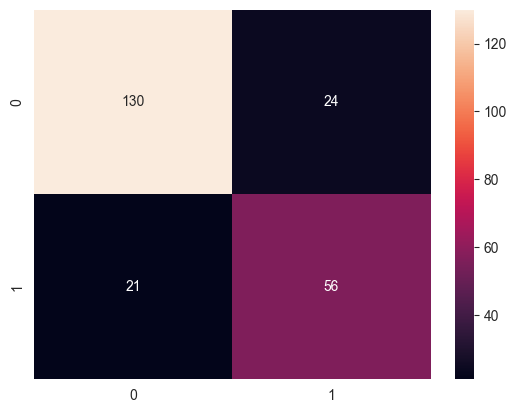

In [88]:
# Decision Tree Classifier with ADASYN
pipeline = Pipeline([
    ('smote', ADASYN(random_state=13)),
    ('dt', DecisionTreeClassifier(random_state=13))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='precision')
print(f"Cross validation precision score: {scores.mean()}")
print(f"F1 scores: {scores}")

# confusion matrix
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

#####
- Oversampling s pomocí ADASYN vyšel hůře než bez použití oversamplingu

#### Parametr tunning pro Decision Tree Classifier

In [112]:
# Defines the pipeline
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=13)),  # SMOTE for oversampling
    ('dt', DecisionTreeClassifier(random_state=13))  # Decision Tree Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'dt__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'dt__min_samples_split': [2, 3, 4, 5, 6],
    'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'dt__criterion': ['gini', 'entropy']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_smote, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

#SHAP
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 2}
Best F1 Score: 0.7666980220152724
              precision    recall  f1-score   support

       False       0.98      0.73      0.84       154
        True       0.64      0.97      0.77        77

    accuracy                           0.81       231
   macro avg       0.81      0.85      0.80       231
weighted avg       0.87      0.81      0.81       231

F1 score: 0.7731958762886598
precision: 0.6410256410256411


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'imblearn.pipeline.Pipeline'>

In [91]:
# Defines the pipeline
pipeline_adasyn = Pipeline([
    ('smote', ADASYN(random_state=13)),  # ADASYN for oversampling
    ('dt', DecisionTreeClassifier(random_state=13))  
])

# Parameter grid for GridSearchCV
param_grid = {
    'dt__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'dt__min_samples_split': [2, 3, 4, 5, 6],
    'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'dt__criterion': ['gini', 'entropy']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_adasyn, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Parameters: {'dt__criterion': 'gini', 'dt__max_depth': 6, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 2}
Best F1 Score: 0.7579098351412913
              precision    recall  f1-score   support

       False       0.95      0.75      0.84       154
        True       0.65      0.92      0.76        77

    accuracy                           0.81       231
   macro avg       0.80      0.83      0.80       231
weighted avg       0.85      0.81      0.81       231

F1 score: 0.7593582887700535
precision: 0.6454545454545455


#### Random Forest Classifier

In [125]:
# Random Forest Classifier with weighted classes
rf = RandomForestClassifier(random_state=13, class_weight='balanced')

param_grid = {
    #'n_estimators': [50, 100, 200],
    #'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 6]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(rf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

#SHAP
best_model = RandomForestClassifier(**grid_search.best_params_, random_state=13, class_weight='balanced')
best_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

print("Shape of shap_values[1]:", shap_values[1].shape)
print("Shape of X_test:", X_test.shape)

# Visualize SHAP summary plot for positive class (Class 1)
shap.summary_plot(shap_values[1], X_test)

# Bar plot of feature importance
shap.summary_plot(shap_values[1], X_test, plot_type='bar')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'min_samples_split': 6}
Best F1 Score: 0.7617989191624054
              precision    recall  f1-score   support

       False       0.94      0.87      0.90       154
        True       0.77      0.88      0.82        77

    accuracy                           0.87       231
   macro avg       0.85      0.88      0.86       231
weighted avg       0.88      0.87      0.88       231

F1 score: 0.8242424242424242
precision: 0.7727272727272727
Shape of shap_values[1]: (67, 2)
Shape of X_test: (231, 67)
[[-0.0072225   0.0072225 ]
 [ 0.00413954 -0.00413954]
 [ 0.00404783 -0.00404783]
 [ 0.00092469 -0.00092469]
 [ 0.00054253 -0.00054253]]


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [93]:

# Defines the pipeline
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=13)),  # SMOTE for oversampling
    ('rf', RandomForestClassifier(random_state=13))  # Random forest Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [ 8, 9, 10, 15],
    'rf__min_samples_split': [5, 6,10, 11, 12, 13],
    'rf__min_samples_leaf': [1, 2, 3, 4, 5, 6]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_smote, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'rf__max_depth': 15, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 13, 'rf__n_estimators': 100}
Best F1 Score: 0.7765180878851885
              precision    recall  f1-score   support

       False       0.93      0.84      0.88       154
        True       0.73      0.87      0.79        77

    accuracy                           0.85       231
   macro avg       0.83      0.85      0.84       231
weighted avg       0.86      0.85      0.85       231

F1 score: 0.7928994082840237
precision: 0.7282608695652174


In [94]:

# Defines the pipeline
pipeline_adasyn = Pipeline([
    ('smote', ADASYN(random_state=13)),  # SMOTE for oversampling
    ('rf', RandomForestClassifier(random_state=13))  # Random forest Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [ 8, 9, 10, 15],
    'rf__min_samples_split': [5, 6,10, 11, 12, 13],
    'rf__min_samples_leaf': [1, 2, 3, 4, 5, 6]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_adasyn, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'rf__max_depth': 8, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Best F1 Score: 0.7809356183703244
              precision    recall  f1-score   support

       False       0.94      0.81      0.87       154
        True       0.70      0.90      0.79        77

    accuracy                           0.84       231
   macro avg       0.82      0.85      0.83       231
weighted avg       0.86      0.84      0.84       231

F1 score: 0.7885714285714286
precision: 0.7040816326530612


#### Nejllepší výsledky byly dosaženy s 

#### AdaBoost Classifier

In [110]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier without oversampling
ada = AdaBoostClassifier(random_state=13)

param_grid = {
    'n_estimators': [50, 90,100, 120],
    'learning_rate': [0.1, 0.4,0.5, 0.6],
    'algorithm': ['SAMME', 'SAMME.R']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(ada, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

#SHAP
best_model = grid_search.best_estimator_
explainer = shap.KernelExplainer(best_model.predict_proba, X_train[:50])  # Smaller background set
shap_values = explainer.shap_values(X_test, nsamples=100)

shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 100}
Best F1 Score: 0.7457242634570103
              precision    recall  f1-score   support

       False       0.92      0.91      0.91       154
        True       0.82      0.83      0.83        77

    accuracy                           0.88       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.88      0.88      0.88       231

F1 score: 0.8258064516129032
precision: 0.8205128205128205


  0%|          | 0/231 [00:00<?, ?it/s]

In [95]:
# Defines the pipeline
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=13)),  # SMOTE for oversampling
    ('ada', AdaBoostClassifier(random_state=13))  # AdaBoost Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'ada__n_estimators': [50, 90,100, 120],
    'ada__learning_rate': [0.1, 0.4,0.5, 0.6],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_smote, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 0.6, 'ada__n_estimators': 90}
Best F1 Score: 0.7710274945140053
              precision    recall  f1-score   support

       False       0.90      0.85      0.88       154
        True       0.73      0.82      0.77        77

    accuracy                           0.84       231
   macro avg       0.82      0.83      0.82       231
weighted avg       0.85      0.84      0.84       231

F1 score: 0.7730061349693251
precision: 0.7325581395348837


##### AdaBoost Classifier - ADASYN

In [96]:
# Defines the pipeline
pipeline_adasyn = Pipeline([
    ('smote', ADASYN(random_state=13)),  # ADASYN for oversampling
    ('ada', AdaBoostClassifier(random_state=13))  # AdaBoost Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'ada__n_estimators': [50, 90,100, 120],
    'ada__learning_rate': [0.1, 0.4,0.5, 0.6],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_adasyn, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 0.1, 'ada__n_estimators': 120}
Best F1 Score: 0.765367267077648
              precision    recall  f1-score   support

       False       0.92      0.81      0.86       154
        True       0.69      0.86      0.76        77

    accuracy                           0.82       231
   macro avg       0.80      0.83      0.81       231
weighted avg       0.84      0.82      0.83       231

F1 score: 0.7630057803468208
precision: 0.6875


#### Nejllepší výsledky byly dosaženy bez použití oversamplingu:
- F1 score: 0.826
- Precision: 0.821

#### LGBM Classifier

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 309, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

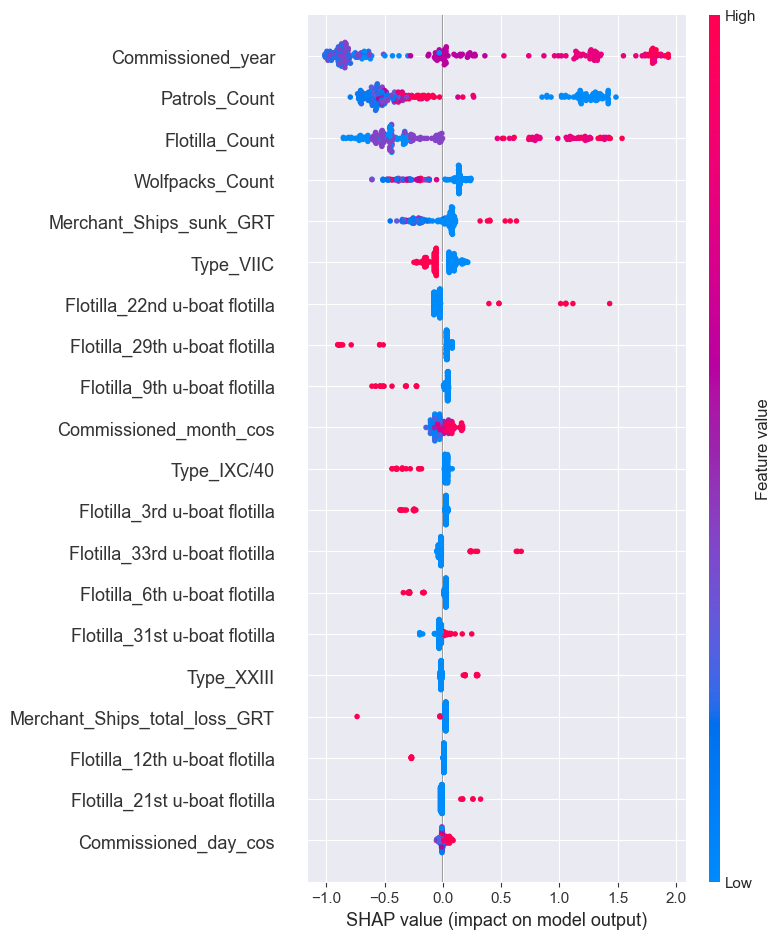

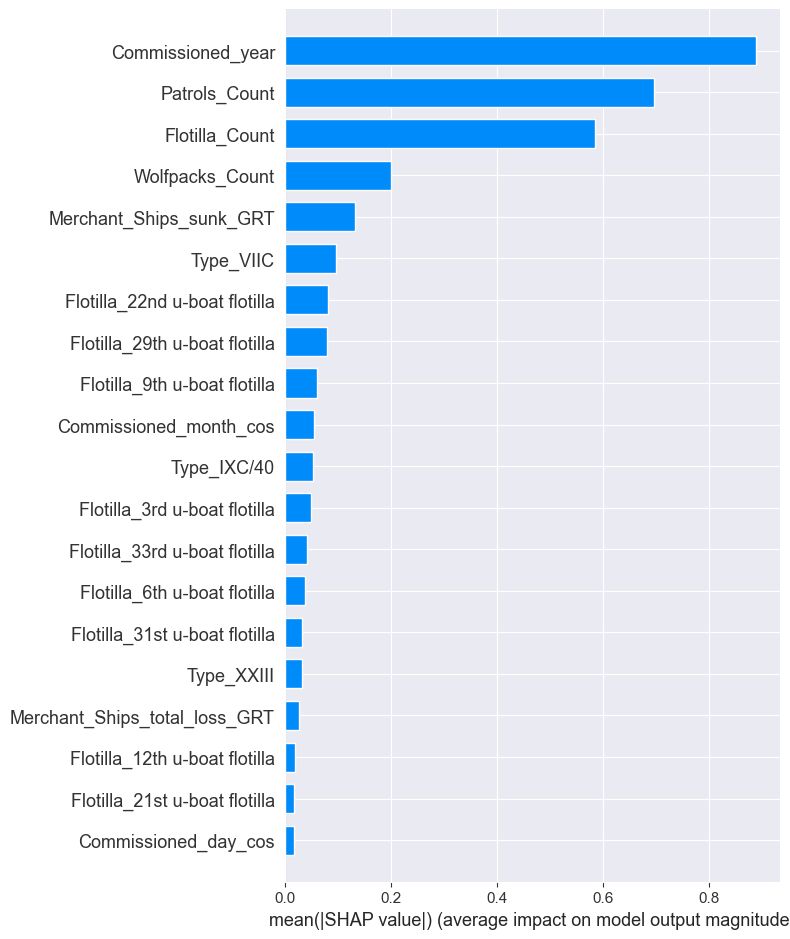

In [100]:
from lightgbm import LGBMClassifier

# LGBM Classifier without oversampling
lgbm = LGBMClassifier(random_state=13, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(lgbm, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

#SHAP
explainer = shap.TreeExplainer(grid_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

In [99]:
# Defines the pipeline
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=13)),  # SMOTE for oversampling
    ('lgbm', LGBMClassifier(random_state=13))  # LGBM Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'lgbm__n_estimators': [50, 100, 200],
    'lgbm__max_depth': [2, 3, 4, 5, 6],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__num_leaves': [31, 50, 100, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_smote, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)
# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 613, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1226, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [98]:
# Defines the pipeline
pipeline_adasyn = Pipeline([
    ('smote', ADASYN(random_state=13)),  # ADASYN for oversampling
    ('lgbm', LGBMClassifier(random_state=13))  # LGBM Classifier
])

# Parameter grid for GridSearchCV
param_grid = {
    'lgbm__n_estimators': [50, 100, 200],
    'lgbm__max_depth': [2, 3, 4, 5, 6],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__num_leaves': [31, 50, 100, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(pipeline_adasyn, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Prints the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)
# Evaluates on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred)}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 1294, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526275 -> initscore=0.105197
[LightGBM] [Info] Start training from score 0.105197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

#### Nejllepší výsledky byly dosaženy bez použití oversamplingu: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
- F1 score: 0.80
- Precision: 0.714

## Shrnutí
- Nejlepší výsledky byly dosaženy s AdaBoost Classifierem bez použití oversamplingu
    - F1 score: 0.826
    - Precision: 0.821
    - Model má jak vysoké F1 scóre tak vysoký precision
    - Při analýze SHAP hodnot bylo zjištěno, že největší vliv na predikci mají hlavně následující parametry
    - Algoritmus postupoval přibližně takto:
         - rok zařazení do služby 
            - Čím později byla zařazena ponorka do služby, tím méně pravděpodobné bylo, že přežije do konce války
         - Počet patrol
            - Nízký počet patrol říká,že byla ponorka buď brzo ztracena a nebo na patroly moc nejezdila a neměla příležitost být ztracena
         - Počet flotil
            - Ponorky s velkým počtem vystřídaných flotil měly větší šanci na přežití
    - Následující parametrty měli mnohem menší vliv na rozhodování algoritmu:
         - Počet vlčích smeček
         - Tonáž potopených obchodních lodí - Velká potopená tonáž, větší šance na přežití
         - Type VIIC - Tyto ponorky moc nepřežívaly
         - Dále v některých flotilách ponorky spíše přežívaly a v některých spíše ne
         - Ponorky zařazené do služby kolem konce a začátku roku měly mírně větší šanci na přežití  
    - Další parametry měly ještě menší vliv na predikci a nejsou dále rozepsány
- Algoritmus LGBM postupoval přibližně stejně, ale měl horší výsledky 
    - F1 score: 0.80
    - Precision: 0.714
    - A nejlepší výsledky byly zase dosaženy bez použití oversamplingu
- Algoritmus Random Forest měl téměř nejlepší výsledky
    - F1 score: 0.824
    - precision: 0.773
- Decision Tree měl nejhorší výsledky:
    - F1 score: 0.773
    - precision: 0.641
    - V rámci Decision Tree byl nejlepší výsledek dosažen s použitím oversamplingu SMOTE    

- AdaBoost umí dobře pracovat s komplexními daty a přizpůsobuje se obtížným případům. Také nemívá problémy s overfittingem.
- To že je nejlepší algoritmus může taky naznačit, že jsou data čistá a nemají přiliš šumu na, který je tento algoritmus citlivý

- Model by mohl být zlepšen například:
    - důkladnějším vyčištěním dat 
    - Parsováním více dat buď z wikipedia(původní zdroj) nebo z jiných zdrojů
         
- V případě realného nasazení(například popisovaná situace s velitelem ponorkové flotily, který chce vybrat na, které ponorky umístit cenný náklad) by vzniklo několik problémů:
    - Model by měl data dostupné pouze do časového okamžiku, kdy by se měl rozhodnout. Navíc jelikož se v rámci války životnost ponorek významně měnila, mohl by mít problém s predikcí.
    - Další problém by byl s možným přednosním cílením nepřátel na tyto vybrané ponorky. Ale jelikož se jedná o ponorky, u kterých se na jednotlivé jedince hůře cílí než například u tanků nebo letadel, nejspíš by se nejednalo o tak velký problém jako první omezení   